In [2]:
import numpy as np

In [3]:
cdl_ofdm_ebno5 = np.load("../data/cdl_ofdm_ebno5.npy", allow_pickle=True)
saved_data = cdl_ofdm_ebno5.item()

In [4]:
for k, v in saved_data.items():
    if isinstance(v, np.ndarray):
        print(f"{k}'s shape: {v.shape}")
    else:
        print(f"{k}: {v}")

channeltype: ofdm
channeldataset: cdl
fft_size: 76
batch_size: 128
num_ofdm_symbols: 14
num_bits_per_symbol: 2
pilot_pattern: kronecker
scenario: O1_60
dataset_folder: data/DeepMIMO
num_ut: 1
num_bs: 1
num_ut_ant: 2
num_bs_ant: 16
direction: uplink
num_streams_per_tx: 2
cyclic_prefix_length: 6
num_guard_carriers: [5, 6]
pilot_ofdm_symbol_indices: [2, 11]
frequencies's shape: (76,)
coderate: 1
k: 1536
n: 1536
num_time_steps: 14
sampling_frequency: 55609.756097560974
no: 0.15811388194561005
h_b's shape: (128, 1, 16, 1, 2, 23, 14)
tau_b's shape: (128, 1, 1, 23)
h_out's shape: (128, 1, 16, 1, 2, 14, 76)
y's shape: (128, 1, 16, 14, 76)
x_rg's shape: (128, 1, 2, 14, 76)
x's shape: (128, 1, 2, 768)
b's shape: (128, 1, 2, 1536)
x_hat's shape: (128, 1, 2, 768)
no_eff: 0.022046716883778572
h_hat's shape: (128, 1, 16, 1, 2, 14, 64)
err_var's shape: (1, 1, 1, 1, 2, 14, 64)
h_perfect's shape: (128, 1, 16, 1, 2, 14, 64)
err_var_perfect: 0.0
b_hat's shape: (128, 1, 2, 1536)
llr_est's shape: (128, 1, 

In [6]:
from AIsim_main2 import Transmitter
showfigure = True
eval_transceiver = Transmitter(channeldataset=saved_data['channeldataset'], channeltype=saved_data['channeltype'], scenario=saved_data['scenario'], \
                               dataset_folder=saved_data['dataset_folder'], direction=saved_data['direction'], \
                    num_ut = saved_data['num_ut'], num_ut_ant=saved_data['num_ut_ant'], num_bs = saved_data['num_bs'], num_bs_ant=saved_data['num_bs_ant'], \
                    batch_size =saved_data['batch_size'], fft_size = saved_data['fft_size'], num_ofdm_symbols=saved_data['num_ofdm_symbols'], num_bits_per_symbol = saved_data['num_bits_per_symbol'],  \
                    subcarrier_spacing=60e3, USE_LDPC = False, pilot_pattern = "kronecker", guards=True, showfig=showfigure, savedata=True)

In [7]:
h_b, tau_b = eval_transceiver.get_channelcir()
print('h_b shape:', h_b.shape) #[batch, num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps] (64, 1, 16, 1, 2, 23, 14)
print('tau_b shape:', tau_b.shape) #[batch, num_rx, num_tx, num_paths] (64, 1, 1, 23)

h_b shape: (128, 1, 16, 1, 2, 23, 14)
tau_b shape: (128, 1, 1, 23)


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

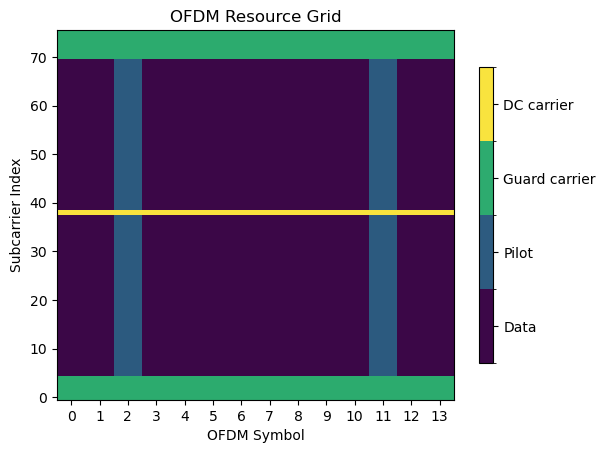

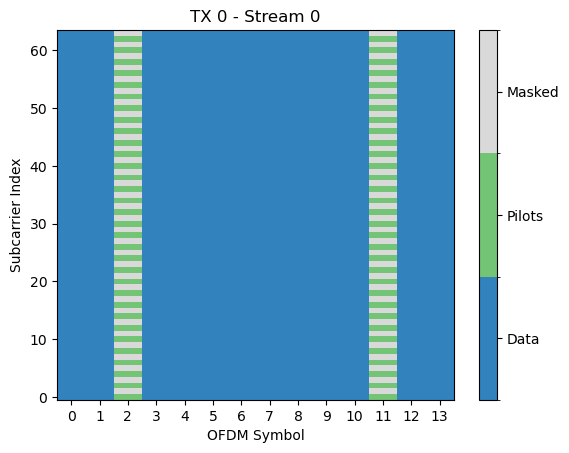

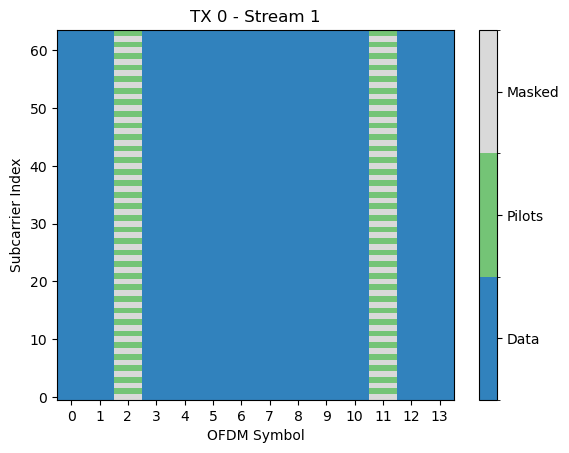

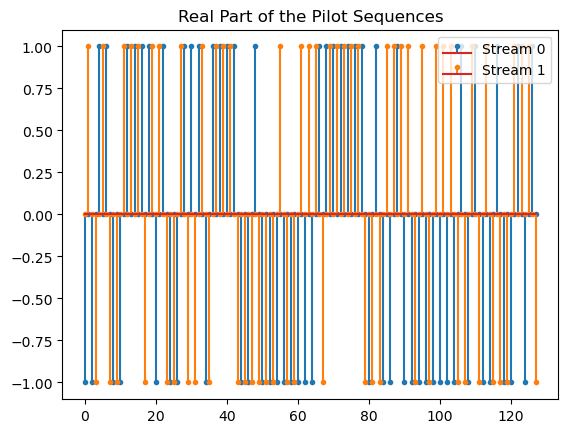

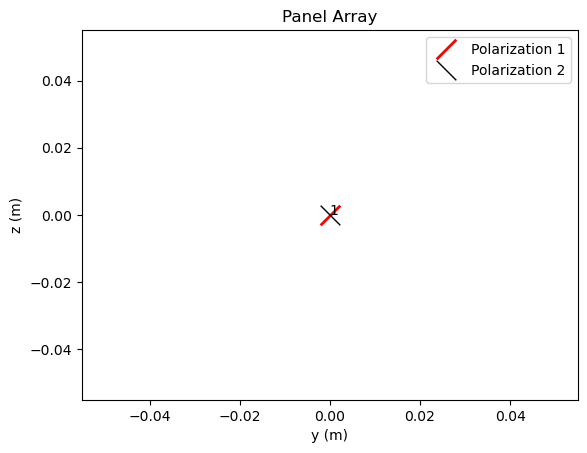

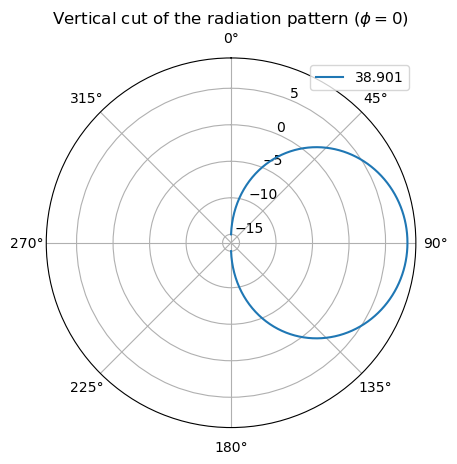

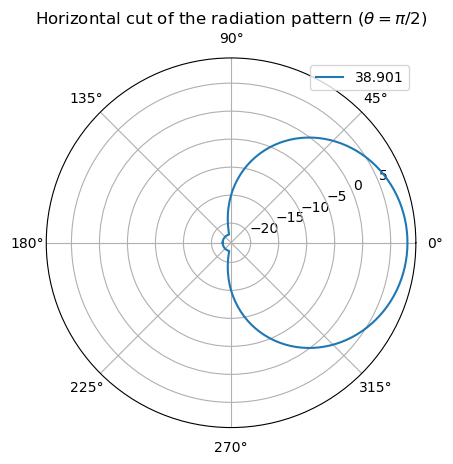

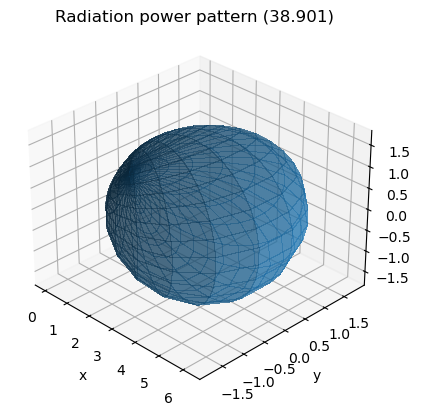

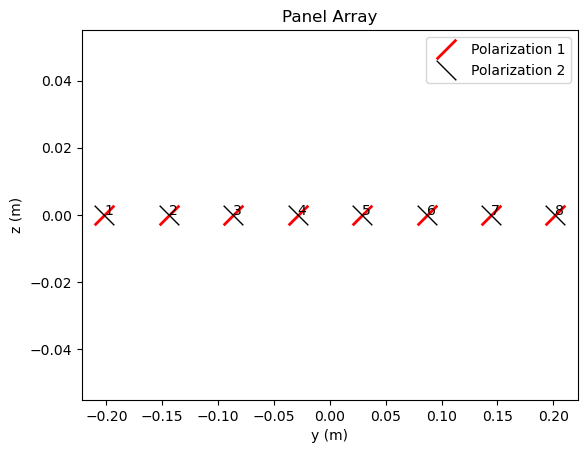

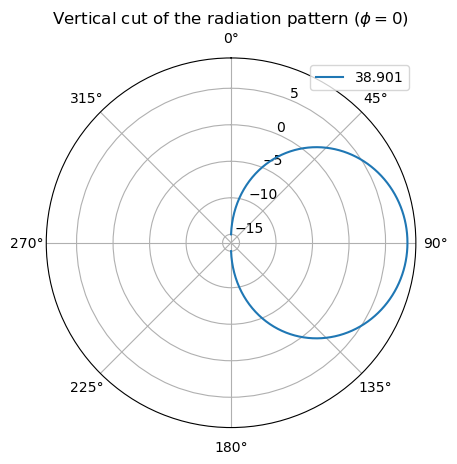

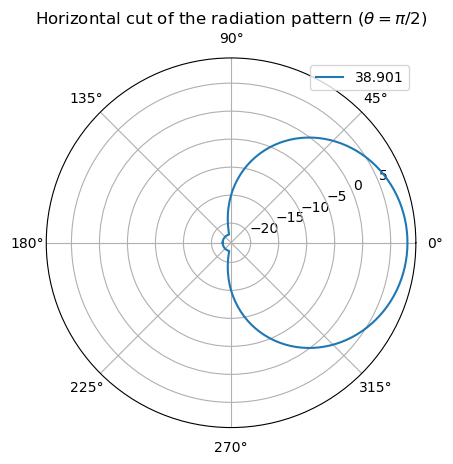

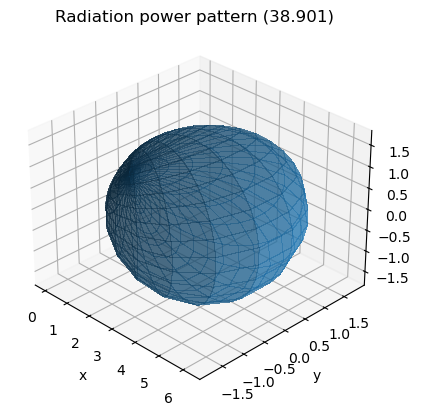

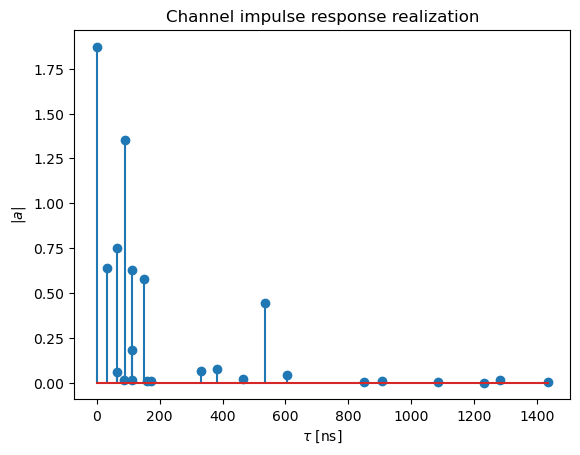

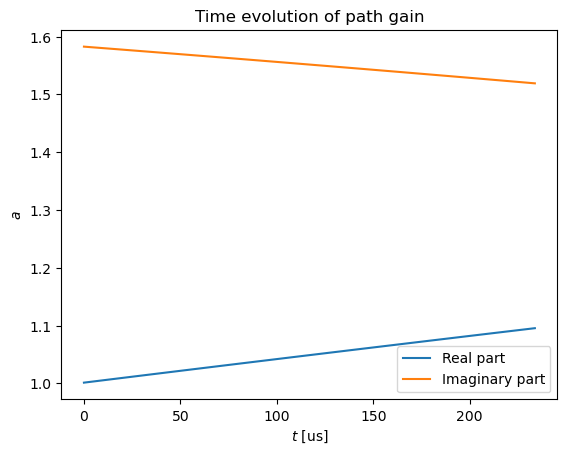

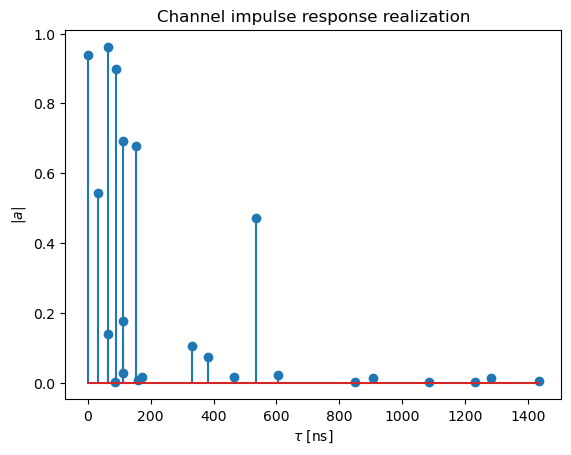

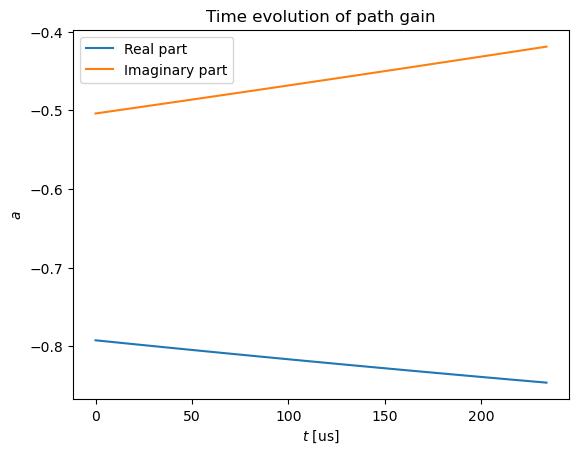

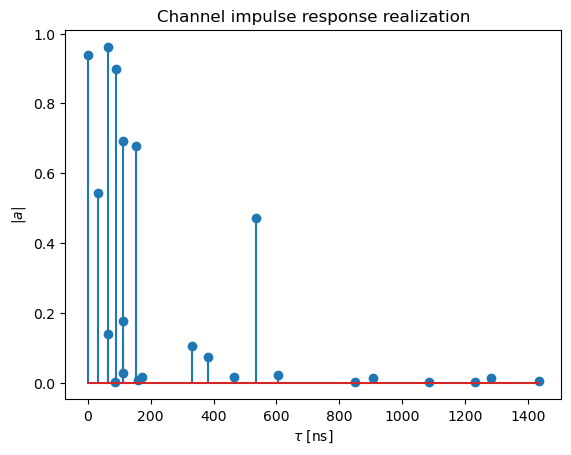

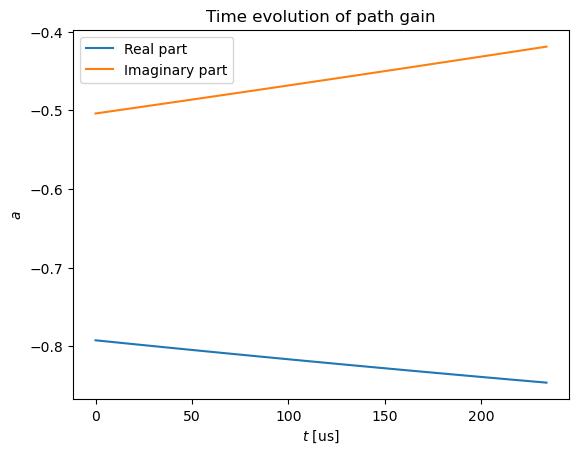

In [9]:
num_time_steps = eval_transceiver.RESOURCE_GRID.num_ofdm_symbols
sampling_frequency=1/eval_transceiver.RESOURCE_GRID.ofdm_symbol_duration
plt.figure()
plt.title("Channel impulse response realization")
plt.stem(tau_b[0,0,0,:]/1e-9, np.abs(h_b)[0,0,0,0,0,:,0])#10 different pathes
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")

plt.figure()
plt.title("Time evolution of path gain")
#x_timesteps = np.arange(num_time_steps)*self.RESOURCE_GRID.ofdm_symbol_duration/1e-6
x_timesteps = np.arange(num_time_steps)/sampling_frequency/1e-6
plt.plot(x_timesteps, np.real(h_b)[0,0,0,0,0,0,:])
plt.plot(x_timesteps, np.imag(h_b)[0,0,0,0,0,0,:])
plt.legend(["Real part", "Imaginary part"])
plt.xlabel(r"$t$ [us]")
plt.ylabel(r"$a$");

h_freq shape: (128, 1, 16, 1, 2, 14, 76)


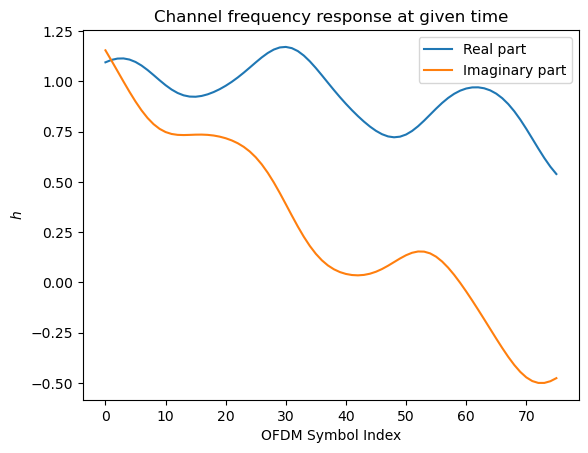

In [10]:
h_out_new = eval_transceiver.get_OFDMchannelresponse(saved_data['h_b'], saved_data['tau_b']) #cir_to_ofdm_channel
print("h_freq shape:", h_out_new.shape) #(64, 1, 16, 1, 2, 14, 76)

In [11]:
h_out = saved_data['h_out']
print("h_out shape:", h_out.shape)

h_out shape: (128, 1, 16, 1, 2, 14, 76)


In [12]:
print(np.allclose(h_out_new, h_out))

True


In [13]:
from sionna.channel import cir_to_ofdm_channel, cir_to_time_channel, ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel

In [14]:
h_freq_tf = cir_to_ofdm_channel(eval_transceiver.frequencies, h_b, tau_b, normalize=True)

In [15]:
print("h_freq_tf shape:", h_freq_tf.shape)

h_freq_tf shape: (128, 1, 16, 1, 2, 14, 76)


In [16]:
print(np.allclose(h_freq_tf.numpy(), h_out))

False


In [17]:
from deepMIMO5 import time_lag_discrete_time_channel, cir_to_time_channel, cir_to_ofdm_channel, subcarrier_frequencies
h_freq_np = cir_to_ofdm_channel(eval_transceiver.frequencies, h_b, tau_b, normalize=True)
print(np.allclose(h_freq_np, h_out))

False


In [25]:
from deepMIMO5 import MyApplyOFDMChannel
x_rg = saved_data['x_rg']
no = saved_data['no']
h_out = saved_data['h_out']
applychannel = MyApplyOFDMChannel(add_awgn=False)
y_new = applychannel([x_rg, h_out])
print('ynew shape:', y_new.shape)

ynew shape: (128, 1, 16, 14, 76)


In [26]:
from sionna.channel import ApplyOFDMChannel
applychannel_tf = ApplyOFDMChannel(add_awgn=False)
y_new_tf = applychannel_tf([x_rg, h_out])
print('y_new_tf shape:', y_new_tf.shape)

y_new_tf shape: (128, 1, 16, 14, 76)


In [28]:
y=saved_data['y']
print(np.allclose(y_new[0,0,0,:,:], y_new_tf[0,0,0,:,:].numpy()))

True


In [29]:
print(np.allclose(y_new[0,0,:,:,:], y_new_tf[0,0,:,:,:].numpy()))

True


In [30]:
print(np.allclose(y_new[0,:,:,:,:], y_new_tf[0,:,:,:,:].numpy()))

True


In [31]:
print(np.allclose(y_new[:,:,:,:,:], y_new_tf[:,:,:,:,:].numpy()))

False


In [33]:
#check mapper
c = saved_data['b'] 
x_new = eval_transceiver.mapper(c) #[batch_size, num_tx, num_streams_per_tx, num_data_symbols]
x_rg_new = eval_transceiver.rg_mapper(x_new) ##complex array[64,1,1,14,76] 14*76=1064 [batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size]
print(x_rg_new.shape)

(128, 1, 2, 14, 76)


In [49]:
saved_data['x_rg'].shape

(128, 1, 2, 14, 76)

In [45]:
print(np.allclose(x_rg_new[:,:,:,:,:], saved_data['x_rg'][:,:,:,:,:]))

False


In [48]:
print(np.allclose(x_rg_new[:,:,:,0,:], saved_data['x_rg'][:,:,:,0,:]))

True


In [44]:
print(np.allclose(x_rg_new[:,:,:,0,:], saved_data['x_rg'][:,:,:,0,:]))

True


In [15]:
deepmimo_ofdm_saved_ebno5 = np.load("../data/cdl_ofdm_saved_ebno5.npy", allow_pickle=True)
saved_data = deepmimo_ofdm_saved_ebno5.item()
for k, v in saved_data.items():
    if isinstance(v, np.ndarray):
        print(f"{k}'s shape: {v.shape}")
    elif isinstance(v, tf.Tensor):
        print(f"{k} tensor's shape: {v.shape}")
    else:
        print(f"{k}: {v}")

channeltype: ofdm
channeldataset: cdl
fft_size: 76
batch_size: 64
num_ofdm_symbols: 14
num_bits_per_symbol: 4
pilot_pattern: kronecker
scenario: O1_60
dataset_folder: data/DeepMIMO
num_ut: 1
num_bs: 1
num_ut_ant: 2
num_bs_ant: 16
direction: uplink
num_streams_per_tx: 2
cyclic_prefix_length: 6
num_guard_carriers: [5, 6]
pilot_ofdm_symbol_indices: [2, 11]
frequencies's shape: (76,)
coderate: 1
k: 3072
n: 3072
no: 0.07905694097280502
h_b's shape: (64, 1, 16, 1, 2, 23, 14)
tau_b's shape: (64, 1, 1, 23)
h_out's shape: (64, 1, 16, 1, 2, 14, 76)
y's shape: (64, 1, 16, 14, 76)
x_rg's shape: (64, 1, 2, 14, 76)
b's shape: (64, 1, 2, 3072)
x_hat's shape: (64, 1, 2, 768)
no_eff: 0.00581008568406105
h_hat tensor's shape: (64, 1, 16, 1, 2, 14, 64)
err_var: 0.0
h_perfect's shape: (64,)
err_var_perfect: 0.0
b_hat's shape: (64, 1, 2, 3072)
llr_est's shape: (64, 1, 2, 3072)
BER: 0.00035858154296875


In [10]:
saved_data['h_hat'].shape

TensorShape([64, 1, 1, 1, 1, 14, 64])

In [5]:
saved_data['channeldataset']
saved_data['fft_size']
saved_data['batch_size']
saved_data['num_ofdm_symbols']
saved_data['num_bits_per_symbol']
saved_data['pilot_pattern']
saved_data['scenario']
saved_data['dataset_folder']
saved_data['num_ut']
saved_data['num_bs']
saved_data['num_ut_ant']
saved_data['num_bs_ant']
saved_data['direction']
saved_data['num_streams_per_tx']
saved_data['cyclic_prefix_length']
saved_data['num_guard_carriers']
saved_data['pilot_ofdm_symbol_indices']
saved_data['frequencies']
saved_data['coderate']

1

In [ ]:
saved_data['k'] #num of information per codeword
saved_data['n'] # Codeword length n = int(RESOURCE_GRID.num_data_symbols * num_bits_per_symbol) #num_data_symbols: if empty 1064*4=4256, else, 768*4=3072
saved_data['no']
saved_data['h_b']
saved_data['tau_b']
saved_data['h_out']
saved_data['y']
saved_data['x_rg']
saved_data['b']
saved_data['x_hat']
saved_data['no_eff']
saved_data['h_hat']
saved_data['err_var']
saved_data['h_perfect']
saved_data['err_var_perfect']
saved_data['b_hat']
saved_data['llr_est']
saved_data['BER']

In [14]:
saved_data['BER']

0.0013427734375

In [56]:
deepmimo_ofdm_saved_ebno5 = np.load("../data/deepmimo_ofdm_saved_ebno5.npy", allow_pickle=True)
saved_data = deepmimo_ofdm_saved_ebno5.item()

In [57]:
from sionna.channel import ApplyOFDMChannel

In [58]:
applychannel = ApplyOFDMChannel(add_awgn=True)
no=saved_data['no']
x_rg=saved_data['x_rg']
h_out=saved_data['h_out']
x_rg = tf.convert_to_tensor(x_rg)
h_out = tf.convert_to_tensor(h_out)
y = applychannel([x_rg, h_out, no])

In [59]:
y.shape

TensorShape([64, 1, 1, 14, 76])

In [60]:
saved_data['y'].shape

(64, 1, 1, 14, 76)

In [61]:
print(np.allclose(y.numpy(), saved_data['y']))

False


In [62]:
from deepMIMO5 import MyApplyOFDMChannel
applychannel = MyApplyOFDMChannel(add_awgn=True)
no=saved_data['no']
x_rg=saved_data['x_rg']
h_out=saved_data['h_out']
y_new = applychannel([x_rg, h_out, no])

In [63]:
y_new.shape

(64, 1, 1, 14, 76)

In [46]:
no

0.0015811388

In [53]:
print(np.allclose(y.numpy(), y_new))

False


In [54]:
print(np.allclose(saved_data['y'][0,0,0,0,0], y_new[0,0,0,0,0]))

False


In [35]:
saved_data['y'][0,0,0,0,:]

array([ 2.03168709e-02+0.11700358j, -4.06768799e-01-0.26666856j,
        3.30204785e-01+0.09554211j,  4.04325165e-02+0.04351137j,
        1.38410896e-01-0.01744035j,  2.45295048e+00+0.43048292j,
        1.92821085e+00-0.86021435j,  2.02049208e+00+0.8810813j ,
       -1.47539294e+00+1.9188901j ,  2.93634176e-01+2.0670385j ,
       -2.20647168e+00-0.9696499j ,  1.06408334e+00-1.5318238j ,
       -3.42593610e-01+0.62594295j, -6.65850222e-01+1.3997688j ,
        1.99814916e+00-0.14700948j,  1.22798264e-01-0.0585698j ,
        3.49165738e-01+0.5556712j ,  1.44528306e+00-0.5658079j ,
       -1.66148365e+00+0.9021003j , -6.72954857e-01-0.2886604j ,
       -1.46427727e+00+0.62561846j,  9.03467238e-01+0.61966383j,
       -4.14557964e-01+1.0580639j ,  3.28744084e-01+0.26826182j,
        1.08918977e+00-0.7049992j ,  1.65248728e+00+0.14777519j,
        6.30522609e-01-0.5497206j , -6.72628522e-01-1.1814688j ,
        1.81101695e-01+1.9248066j , -3.41105759e-01+0.71832716j,
        4.72803116e-02-1.

In [36]:
y_new[0,0,0,0,:]

array([-0.03991484-0.38937676j,  0.09912405+0.06895108j,
       -0.03455912-0.11664158j, -0.02885672-0.1889352j ,
       -0.02840974-0.10515035j,  2.4424355 -0.11060016j,
        2.0707    -0.6941113j ,  2.29967   +0.6702544j ,
       -1.0845194 +1.9152354j , -0.32267714+1.7442445j ,
       -2.4240248 -0.7291124j ,  1.3686078 -1.8178126j ,
       -0.7891866 +0.26212424j, -1.0389568 +1.0723753j ,
        2.4458723 -0.21682803j,  0.22644097+0.04370978j,
        0.1890844 +0.09104568j,  1.5922419 -0.640265j  ,
       -1.4608622 +0.4012045j , -1.3675193 -0.11177567j,
       -1.2281973 +0.49456668j,  0.85097283+0.70656294j,
       -0.5787529 +0.74675345j,  0.28142354-0.25295836j,
        0.9684461 -0.5685219j ,  1.4828781 +0.5124516j ,
       -0.01968686-0.45028728j, -0.7074252 -1.151564j  ,
        0.20987149+2.3038802j , -0.37644294+0.70845145j,
       -0.38741502-1.3197747j ,  0.50141245+0.21639943j,
        0.71397   +0.08600387j, -0.38363189-0.35575998j,
       -2.4235537 -0.24373747j,

In [55]:
saved_data['y'].shape

(64, 1, 1, 14, 76)